# Import Libraries

In [150]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from windrose import WindroseAxes

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping

import sys
import keras_tuner as kt
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F

# Load Dataset into Jupyter

In [172]:
df = pd.read_csv("C:/Users/kelby/Desktop/Master's in AI/5-Deep Learning (DSCI-619)/3 - Classification - TF PT/PRSA_Data/PRSA_Data1.csv")

# Display the merged dataset
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


### Check datatypes to verify they're correct. 

In [173]:
df.dtypes

No           int64
year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
dtype: object

### Check for null values

In [174]:
df.isnull().sum(axis = 0)

No            0
year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64

### Dropped station, not needed for analysis
### Dropped rows with null values since dataset is large enough to offset these few observations

In [175]:
df = df.drop('station', axis=1)
df = df.dropna()

In [176]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


Index built into the dataset is not necessary for classification. Dropped column and reset index. 
Feature engineering application to date columns. 
Also, dropped date-related columns to remove redundancy. 

In [177]:
df.drop(columns=['No'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [178]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


In [179]:
df.dtypes

year       int64
month      int64
day        int64
hour       int64
PM2.5    float64
PM10     float64
SO2      float64
NO2      float64
CO       float64
O3       float64
TEMP     float64
PRES     float64
DEWP     float64
RAIN     float64
wd        object
WSPM     float64
dtype: object

### Converted categorical variables to numerical variables for corr()

In [119]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [120]:
wd_encoded = encoder.fit_transform(df[['wd']])  # Encode the 'wd' column
wd_labels = encoder.get_feature_names_out(['wd'])  # Get transformed column names

df_encoded = pd.DataFrame(wd_encoded, columns=wd_labels)  # Convert to DataFrame

In [121]:
df = df.drop(columns=['wd'])  # Drop original categorical column
df = pd.concat([df, df_encoded], axis=1)  # Merge encoded columns

In [122]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Below, we can observe features with high correlation to PM2.5

### When testing a df copy for correlation, WSPM seems to be the highest correlation with WD. 
WSPM also has a really high negative correlation with NO2 so there may be an indirect relationship between the 3. 

# Train Test Split

In [123]:
X = df.drop(columns=wd_labels)  # Features
y = df[wd_labels]  # One-hot encoded labels

#Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [124]:
print(y_train.sum(axis=1).unique())  # Should always be exactly `1`

[1.]


# Normalize Data
This is done after the split to prevent data leakage

In [125]:
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [126]:
print(f'Min: {X_train.min()}, Max: {X_train.max()}')

Min: 0.0, Max: 1.0000000000000002


The above pulls minimum and maximum values that help us ensure that values scale down correctly to between 0 and 1. 

In [127]:
X_train.shape

(25452, 15)

Checked input value for first layer

In [128]:
y_train.shape

(25452, 16)

Checked label count to verify loss. Since we're over 10, we use categorical_crossentropy.

As shown above, after encoding, we are returning some label values with 0's which is completely destroying the model.
*Note:* This is no longer displayed above, as the results no longer err after resolving the issue. It seems get_dummies() was removing 1 of 16 labels. Switching to OneHotEncoder resolved this. 

# TensorFlow

In [23]:
tf_model = keras.Sequential()
tf_model.add(layers.Dense(15, activation='relu')) # per feedback from last weeks assignment, first layer begins with the same neurons as features
tf_model.add(layers.Dense(20, activation='relu')) # first hidden layer with 20 neurons, per requirements of the assignment
tf_model.add(layers.Dense(10, activation='relu')) # second hidden layer with 10 neurons, as above
tf_model.add(layers.Dense(16, activation='softmax')) # final layer to match the number of labels for prediction

tf_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
%%time
# set random seed 
tf.random.set_seed(1)
# Fit the model and save the results in history
history = tf_model.fit(x=X_train, y=y_train, batch_size=32, epochs=100,
          validation_data=(X_test,y_test), verbose= 1
          )

Epoch 1/100
796/796 [==============================] - 2s 2ms/step - loss: 2.6168 - accuracy: 0.1630 - val_loss: 2.5056 - val_accuracy: 0.1993
Epoch 2/100
796/796 [==============================] - 2s 2ms/step - loss: 2.4694 - accuracy: 0.1967 - val_loss: 2.4236 - val_accuracy: 0.2070
Epoch 3/100
796/796 [==============================] - 2s 2ms/step - loss: 2.4114 - accuracy: 0.2047 - val_loss: 2.3862 - val_accuracy: 0.2098
Epoch 4/100
796/796 [==============================] - 2s 2ms/step - loss: 2.3831 - accuracy: 0.2106 - val_loss: 2.3657 - val_accuracy: 0.2150
Epoch 5/100
796/796 [==============================] - 2s 3ms/step - loss: 2.3657 - accuracy: 0.2159 - val_loss: 2.3571 - val_accuracy: 0.2169
Epoch 6/100
796/796 [==============================] - 2s 3ms/step - loss: 2.3529 - accuracy: 0.2194 - val_loss: 2.3419 - val_accuracy: 0.2232
Epoch 7/100
796/796 [==============================] - 2s 3ms/step - loss: 2.3433 - accuracy: 0.2209 - val_loss: 2.3328 - val_accuracy: 0.2229

In [25]:
# Convert to df for performance visualization
trainhist = pd.DataFrame(history.history)
# add epoch column for x value in visualization/progression
trainhist['epoch'] = history.epoch
# results
trainhist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,2.201011,0.257190,2.229564,0.245796,95
96,2.198872,0.254833,2.227260,0.248153,96
97,2.199653,0.254911,2.221512,0.248782,97
98,2.199484,0.256954,2.227775,0.246896,98
99,2.198917,0.256522,2.225793,0.245482,99


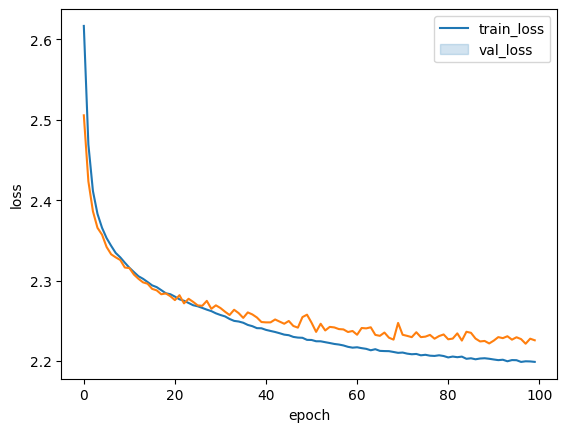

In [26]:
# Training loss
sns.lineplot(x='epoch', y='loss', data=trainhist)
# Validation loss
sns.lineplot(x='epoch', y='val_loss', data=trainhist)
# Legend
plt.legend(labels=['train_loss', 'val_loss'])

The model above definitely overfits the data. We can see that by the continued improvement on training data with a plateau in validation loss. 

In [27]:
X_train.shape[1] #input

15

In [28]:
y_train.shape[1] #output

16

In [45]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)


In [57]:
def model_builder(hp):
    model = keras.Sequential()

    hp_units1 = hp.Int('unit1', min_value=20, max_value=100, step=5)
    hp_units2 = hp.Int('unit2', min_value=10, max_value=50, step=2)
    hp_dropout1 = hp.Float('rate1', min_value = 0.2, max_value=0.8, step=0.1)
    hp_dropout2 = hp.Float('rate1', min_value = 0.2, max_value=0.8, step=0.1)

    model.add(layers.Dense(units=15, activation='relu')) # Input Layer

    model.add(layers.Dense(units = hp_units1, activation='relu')) # Hidden layer 1
    model.add(Dropout(rate=hp_dropout1))

    model.add(layers.Dense(units = hp_units2, activation='relu')) # Hidden layer 2
    model.add(Dropout(rate=hp_dropout2))

    model.add(layers.Dense(units=16, activation='softmax')) # Output Layer

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [58]:
tuner = kt.Hyperband(model_builder, #Specify the model
                     objective = 'val_loss', #Specify the objective funciton
                     max_epochs = 100, #Specify the maximum epochs
                     directory = 'Project3', #Specify the file path
                     project_name = 'wd_pred')

Reloading Tuner from Project3\wd_pred\tuner0.json


In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [60]:
shutil.rmtree('Project3')
# Perform search
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stop])

Trial 254 Complete [00h 01m 13s]
val_loss: 2.275911808013916

Best val_loss So Far: 2.1935341358184814
Total elapsed time: 01h 11m 55s


In [97]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters found: {best_hps.values}")

print()
print(f"{'The optimal number of units in the input layer:':<60}{best_hps.get('units'):<10}") 
print(f"{'The optimal number of units in the first hidden layer:':<60}{best_hps.get('unit1'):<10}") 
print(f"{'The optimal dropout rate in the first hidden layer:':<60}{best_hps.get('rate1'):<10}")
print(f"{'The optimal number of units in the second hidden layer:':<60}{best_hps.get('unit2'):<10}")
print(f"{'The optimal dropout rate in the second hidden layer:':<60}{best_hps.get('rate1'):<10}")
print(f"{'The optimal learning rate for the optimizer of Adam:':<60}{best_hps.get('learning_rate'):<10}")

Best hyperparameters found: {'units': 10, 'rate': 0.4, 'learning_rate': 0.0001, 'unit1': 90, 'unit2': 50, 'rate1': 0.2, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}

The optimal number of units in the input layer:             10        
The optimal number of units in the first hidden layer:      90        
The optimal dropout rate in the first hidden layer:         0.2       
The optimal number of units in the second hidden layer:     50        
The optimal dropout rate in the second hidden layer:        0.2       
The optimal learning rate for the optimizer of Adam:        0.0001    


In [62]:
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
796/796 [==============================] - 3s 3ms/step - loss: 2.5468 - accuracy: 0.1794 - val_loss: 2.4147 - val_accuracy: 0.2107
Epoch 2/50
796/796 [==============================] - 2s 3ms/step - loss: 2.4168 - accuracy: 0.2061 - val_loss: 2.3624 - val_accuracy: 0.2200
Epoch 3/50
796/796 [==============================] - 2s 2ms/step - loss: 2.3754 - accuracy: 0.2168 - val_loss: 2.3360 - val_accuracy: 0.2243
Epoch 4/50
796/796 [==============================] - 2s 2ms/step - loss: 2.3542 - accuracy: 0.2199 - val_loss: 2.3207 - val_accuracy: 0.2271
Epoch 5/50
796/796 [==============================] - 2s 2ms/step - loss: 2.3439 - accuracy: 0.2251 - val_loss: 2.3171 - val_accuracy: 0.2309
Epoch 6/50
796/796 [==============================] - 2s 2ms/step - loss: 2.3276 - accuracy: 0.2274 - val_loss: 2.3016 - val_accuracy: 0.2280
Epoch 7/50
796/796 [==============================] - 2s 3ms/step - loss: 2.3197 - accuracy: 0.2309 - val_loss: 2.2899 - val_accuracy: 0.2359
Epoch 

The above reflects a val_loss decrease from 2.2258 to 2.1923 and accuracy from 24.55% to 25.55%.

# PyTorch

New Train Test Split to fit PyTorch single y-value requirement

In [180]:
X = df.drop('wd', axis=1)  # Features
y = df['wd']

#Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

### Encode labels and convert arrays to tensors

In [181]:
X_train = torch.tensor(X_train.values.astype(np.float32))
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Converts labels to integers
y_test = label_encoder.transform(y_test)
y_train = torch.tensor(y_train.astype(np.int64)).reshape(-1, 1)

In [182]:
print(X_train.shape)  # Features
print(y_train.shape)  # Labels

torch.Size([25452, 15])
torch.Size([25452, 1])


In [183]:
X_test = torch.tensor(X_test.values.astype(np.float32))
y_test = torch.tensor(y_test.astype(np.int64)).reshape(-1, 1)

print(X_test.shape)  # Features in the test set
print(y_test.shape)  # Labels in the test set


torch.Size([6363, 15])
torch.Size([6363, 1])


Verified that all tensors line up correctly

In [202]:
print(X_train.shape[1])

15


In [203]:
print(len(y_train.unique()))

16


In [204]:
input_size = X_train.shape[1]
output_size = len(y_train.unique())
hidden_size = [20, 10]

print(input_size)
print(output_size)

15
16


# Define the Classification Model

In [266]:
class LinearClassificationModel(torch.nn.Module):
    # constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearClassificationModel, self).__init__()
        self.hidden1 = torch.nn.Linear(input_size, hidden_size[0])
        self.hidden2 = torch.nn.Linear(hidden_size[0], hidden_size[1])
        self.predict = torch.nn.Linear(hidden_size[1], output_size)
    # forward function
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        y_pred = F.log_softmax(self.predict(x), dim=1)
        return y_pred

In [267]:
pt_model = LinearClassificationModel(input_size, hidden_size, output_size)
l = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pt_model.parameters(), lr=0.01)

In [268]:
y_train = y_train.squeeze()  # Removes the extra dimension
y_test = y_test.squeeze()

In [269]:
%%time

# set random seeds
torch.manual_seed(1)
np.random.seed(1)

# set epochs

num_epochs=500

train_loss = [None]*num_epochs
validation_loss = [None]*num_epochs
for epoch in range(num_epochs):
    output = pt_model(X_train)
    loss = l(output, y_train)
    train_loss[epoch] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Stop tracking gradient
    y_pred = pt_model(X_test).detach()
    val_loss = l(y_pred, y_test)
    validation_loss[epoch] = val_loss.item()
    if epoch % 100 == 0:
        print(f"epoch {epoch}, loss = {loss.item():.4f} and val_loss = {val_loss:.4f}")

epoch 0, loss = 55.2769 and val_loss = 605.5320
epoch 100, loss = 2.8024 and val_loss = 2.8040
epoch 200, loss = 2.7847 and val_loss = 2.7857
epoch 300, loss = 2.7692 and val_loss = 2.7695
epoch 400, loss = 2.7556 and val_loss = 2.7554
CPU times: total: 21.6 s
Wall time: 2.73 s


In [270]:
trainhist3 = pd.DataFrame({'train_loss': train_loss, 'val_loss': validation_loss, 'epoch':np.arange(num_epochs)})

trainhist3.tail()

,train_loss,val_loss,epoch
495,2.744361,2.743567,495
496,2.744250,2.743451,496
497,2.744139,2.743335,497
498,2.744029,2.743219,498
499,2.743918,2.743104,499


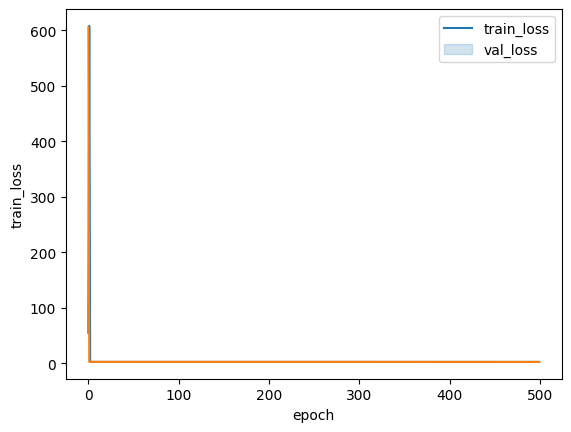

In [271]:
# Train loss
sns.lineplot(x='epoch', y ='train_loss', data =trainhist3)
# Validation loss
sns.lineplot(x='epoch', y ='val_loss', data =trainhist3)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

Interestingly, the validation loss appears to shrink more than the training loss. <br /> 
We have extremely early plateau occurring after a very steep drop. <br />
The curve could likely benefit from dropout, but regardless, <br />
it converges really well with epoch 500 showing a slightly lower loss than training_loss. 

### For the above reasons, I would say that this slightly underfits the data. 